# Ultrasonic Sensor - Chirp Signal

A chirp signal in ultrasonic sensing is fundamentally different from a burst. While a burst is a short group of pulses at a fixed frequency, a chirp is a pulse whose frequency continuously sweeps during its duration, for example from 38Khz to 42 Khz over a few milliseconds. Chirp signals are widely used for improved resolution and noise immunity in applications like sonar and untrasonic ranging.

### What is a Chirp Signal?

A chirp signal is a sinosoidal waveform with a freqeuncy that varies over time - either linearly or non-linear (exponentially, hyperbolically, etc). For example, a linear chirp increases or decreases its frequenc at a constant rate.

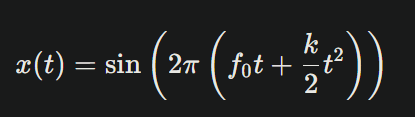

where f0 is the starting frequency and k is the frequency sweep rate.

### How to simulate a chirp signal in python

We can generate a chirp signal using the scipy.signal .chirp function, whioch lets you specify the starting frequency, ending frequency, time duration and sweep type. Here is how we can adapt the code to produce a chirp waveform.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp

In [2]:
# Parameters
num_signals = 2               # How many chirps to send (simulate multiple pings)
burst_spacing = 0.001        # Time between each chirp burst (seconds) - 2 ms
num_pulses = 30             # How many cycles each chirp has
frequency = 40000            # Nominal frequency of Ultrasonic (Hz) - 40 kHz
sampling_rate = 1_000_000    # Sampling frequency for simulation - 1 MHz - very high for accuracy
f0 = 15000                    # Chirp starts at 5 Khz
f1 = 42000                   # Chirp ends at 42 Khz

duration = num_pulses / frequency                     # Length of each chirp signal in seconds 
samples_per_chirp = int(duration * sampling_rate)     # How many samples points per chirp
samples_between = int(burst_spacing * sampling_rate)  # How many zeros between chirps

print(f"One chirp duration: {duration:.6f} s, samples: {samples_per_chirp}")


One chirp duration: 0.000750 s, samples: 750


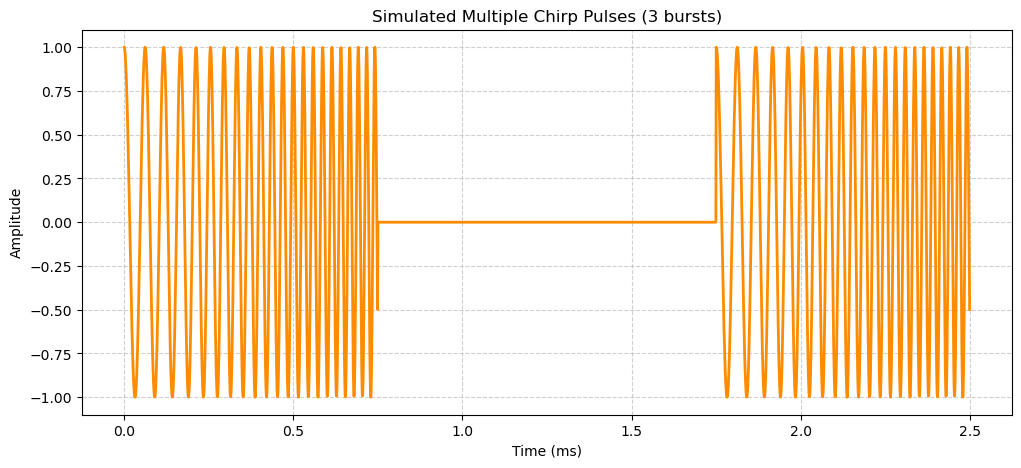

In [3]:
# Time array for one chirp
t_chirp = np.arange(0, duration, 1 / sampling_rate)
chirp_sig = chirp(t_chirp, f0=f0, f1=f1, t1=duration, method='linear')

# Build the composite signal - we repeat the chirp 3 times, separated by silences (zeros)
total_samples = num_signals * samples_per_chirp + (num_signals - 1) * samples_between
multi_signal = np.zeros(total_samples)

for i in range(num_signals):
    offset = i * (samples_per_chirp + samples_between)
    multi_signal[offset : offset + samples_per_chirp] = chirp_sig

# Time axis for composite signal
t_total = np.arange(0, total_samples) / sampling_rate

# Plot
plt.figure(figsize=(12, 5))
plt.plot(t_total * 1e3, multi_signal, color='darkorange', linewidth=2)
plt.title("Simulated Multiple Chirp Pulses (3 bursts)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Reflection of the Sent chirp

When a signal relects off an object, it comes back after a certain delay (the ToF). It is also weaker (attenuated) and there is always noise

* Distance is the sensor-to-reflector path (meters)
* Speed of sound in water is 1480 m/s 

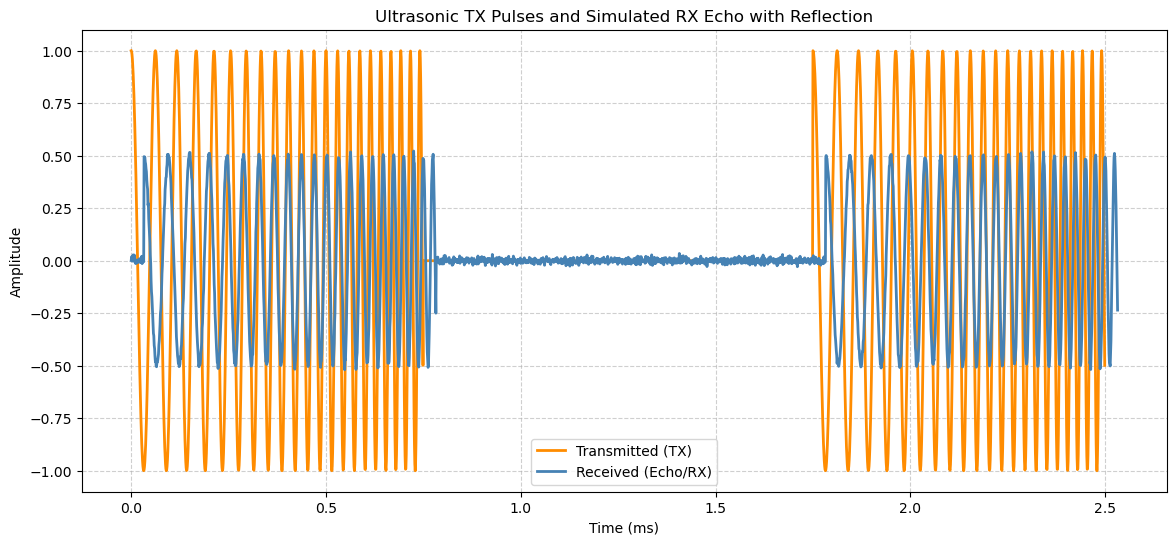

In [4]:
# Reflection simulation

# Reflector distance (meters)
distance = 0.025       # 25 mm distance between pipe and reflector
speed_of_sound = 1480  # Speed of sound in water (m/s)
tof = 2 * distance / speed_of_sound  # Round trip time (seconds)
delay_samples = int(tof * sampling_rate)

# RX signal: delayed and attenuated echo + noise
attenuation = 0.5              # echo reflection strength (adjust for realism)
rx_signal = np.zeros(len(multi_signal) + delay_samples)
rx_signal[delay_samples:delay_samples + len(multi_signal)] = attenuation * multi_signal
rx_signal += 0.01 * np.random.randn(rx_signal.size)  # Add noise (adjust if needed)

# Time axis for RX signal
t_rx = np.arange(rx_signal.size) / sampling_rate

# Plot both signals
plt.figure(figsize=(14, 6))
plt.plot(t_total * 1e3, multi_signal, label='Transmitted (TX)', c='darkorange', linewidth=2)
plt.plot(t_rx * 1e3, rx_signal, label='Received (Echo/RX)', c='steelblue', linewidth=2)
plt.title('Ultrasonic TX Pulses and Simulated RX Echo with Reflection')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Cross-Correlation (Example for understanding)

Cross-correlation acts as a matched filter to figure out the delay between the transmitted chirp and the received chirp signal.

We start with two simple signals:

**Sent (x):**  
x = [0, 0, 1, 1, 1, 0, 0, 0]

and 

**Received (y):**  
y = [0, 0, 0, 0, 1, 1, 1, 0]

`y` is the same as `x`, but **shifted (delayed)** to the right by 2 or 3 steps.  
We want to find how much delay there is!


## 🌀 Step 1: What “Slide” Means

We will **slide** (move) `y` left and right across `x`.

For each slide position `s`, we:

1. Create a shifted version of `y` (`y_shifted`)
2. Multiply `x` and `y_shifted` element-by-element
3. Add up all those products

That total sum is the **match score** — a measure of how well they align.

---

## 🧮 Step 2: Slide-by-Slide Example

| Shift (s) | y_shifted                 | x * y_shifted             | Sum (match score) |
|------------|--------------------------|---------------------------|-------------------|
| -4 | [1, 1, 1, 0, 0, 0, 0, 0] | [0, 0, 1, 0, 0, 0, 0, 0] | 1 |
| -3 | [0, 1, 1, 1, 0, 0, 0, 0] | [0, 0, 1, 1, 0, 0, 0, 0] | 2 |
| **-2** | **[0, 0, 1, 1, 1, 0, 0, 0]** | **[0, 0, 1, 1, 1, 0, 0, 0]** | **3 ← Peak** |
| -1 | [0, 0, 0, 1, 1, 1, 0, 0] | [0, 0, 0, 1, 1, 0, 0, 0] | 2 |
| 0 | [0, 0, 0, 0, 1, 1, 1, 0] | [0, 0, 0, 0, 1, 0, 0, 0] | 1 |
| +1 | [0, 0, 0, 0, 0, 1, 1, 1] | [0, 0, 0, 0, 0, 0, 0, 0] | 0 |
| +2 | [0, 0, 0, 0, 0, 0, 1, 1] | [0, 0, 0, 0, 0, 0, 0, 0] | 0 |
| +3 | [0, 0, 0, 0, 0, 0, 0, 1] | [0, 0, 0, 0, 0, 0, 0, 0] | 0 |

---

## 🏆 Step 3: Finding the Best Match

The **highest score = 3** happens at **s = -2**.

That means `y` needs to move **2 steps to the right** to line up perfectly with `x`.

---

## 🧠 Step 4: Visualization

Original signals:

**x (you) = 0 0 1 1 1 0 0 0**
**y (friend) = 0 0 0 0 1 1 1 0**

After sliding `y` right by 2 (s = -2):

**y_shifted = 0 0 1 1 1 0 0 0**

They now **match perfectly!**

---


Estimated delay: 33 samples
Estimated ToF: 33.00 µs (0.000033 seconds)
Estimated distance: 0.024420 m


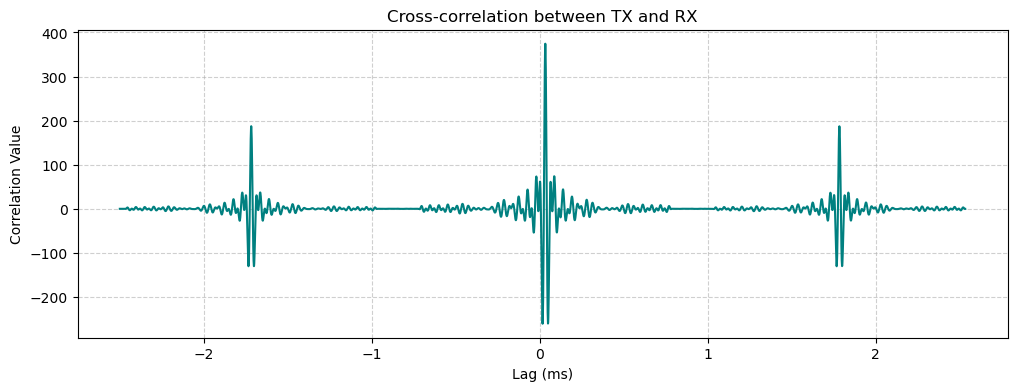

In [5]:
from scipy.signal import correlate

# --- 1. Beat waveform (mixing) ---
# Use only the non-padded length
'''
min_len = min(len(multi_signal), len(rx_signal))
beat_waveform = multi_signal[:min_len] * rx_signal[:min_len]

plt.figure(figsize=(12, 4))
plt.plot(t_total[:min_len] * 1e3, beat_waveform, color='purple')
plt.title('Beat Waveform (TX * RX)')
plt.xlabel('Time (ms)')
plt.ylabel('Beat Amplitude')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
'''
# --- 2. Cross-correlation (for accurate TOF estimation) ---
corr = correlate(rx_signal, multi_signal, mode='full')
lags = np.arange(-len(multi_signal)+1, len(rx_signal))
delay_index = np.argmax(corr)
estimated_delay_samples = lags[delay_index]
estimated_delay_time_sec = estimated_delay_samples / sampling_rate
estimated_delay_time_us = estimated_delay_time_sec * 1e6  # microseconds

print(f"Estimated delay: {estimated_delay_samples} samples")
print(f"Estimated ToF: {estimated_delay_time_us:.2f} µs "
      f"({estimated_delay_time_sec:.6f} seconds)")

''' This is to verify the result '''
est_distance = (estimated_delay_time_us * 10**-6 * speed_of_sound)/2   ## divide by 2 is due to round trip

print (f"Estimated distance: {est_distance:.6f} m")

 
plt.figure(figsize=(12, 4))
plt.plot(lags / sampling_rate * 1e3, corr, color='teal')
plt.title('Cross-correlation between TX and RX')
plt.xlabel('Lag (ms)')
plt.ylabel('Correlation Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Issues it tries to solve

## Oscillations

The signal received will usually be identical in shape, just delayed and attenuated under normal conditions. Even if there are hundreds of oscillations, Matched filtering  (cross-correlation) checks

**If the known transmitted signal is shifted by some amount, how similar is it to the received signal?**

* When the transmitted and received signals are not aligned, the product of the two oscillating signals alternates between positive and negative rapidly -> sums to nearly zero
* When they are aligned, the phases match at every moment -> positive contributions add coherently -> large correlation peak.

**Despite the oscillations, only the correct alignment causes the parts of both signals to work together and make the result stronger at the correct delay. Oscillations do not hurt; they sharpen the peak** 

## Phase differences

There are two kinds of phase shifts:

### (1) Constant phase shifts 

This changes the overall sign or complex phase of the correlation result - it does not affect the position of the correlation peak. ToF remains unaffected

### (2) Time varying phase distortions (dispersion, flow turbulence, etc)

If the shape of the received waveform no longer matches the transmitted signal (because frequency components arrive with slightly different delays), then the correlation peak broadens or weakens, but it still occurs near the true delay.

That's why:

* Wideband chirp gives better time resolution but is more sensitive to distortions
* Narrowband chirps are more robust but less precise.


**Even if each instant of the received waveform is noisy or phase-shifted, the correlation process integrates energy coherently over N samples**

The SNR improvement is proportional to N. This is called processing gain or pulse compression gain.

# Limitations of Matched Filters (Cross-correlation)

* Severe multipath (mutiple echoes overlapping) causes multiple peaks in correlation output (may confuse ToF Detection)
* Strong Doppler shift (flow causing large frequency offest) causes frequency sweep of echo to shift slightly. The correlation peak shifts or reduces.
* 


# TODO:

Research on the topics mentioned below.

If the channel distorts the chirp (attenutation vs frequency, disperion, multipath, Doppler):

1. Change the chirp shape (bandwidth, duration -> linear -> non-linear)
2. Pre-/Post-equalize (undo channel frequency response)
3. Use robust signaling (complementary codes, phase codes, segmented chirps)
4. Adapt processing (mismatched filters, windowing, adaptive filters)
5. Use diversity & averaging (multiple pings)

1) Start simple: tune bandwidth (B) and duration (T)

Reduce bandwidth (narrower B) → more robust to frequency-dependent attenuation/distortion, but coarser time resolution (wider correlation peak).

Reduce duration (shorter T) → reduces smear from time-varying distortion or motion during chirp, at cost of less processing gain (lower SNR).

Trade-off recipe: if your echoes are severely distorted, try decreasing B in steps (e.g., from 10 kHz → 5 kHz) or shorten T (e.g., half the chirp length) and check correlation peak width & SNR.

2) Use amplitude tapering / windowing on the chirp

Apply a window (Hanning/Hamming/Tukey) to the chirp amplitude envelope at TX (and/or to the matched filter at RX).

Why: reduces sidelobes of the matched-filter output (fewer false peaks from multipath) — makes detection more reliable.

Trade-off: main lobe widens slightly (worse resolution) but sidelobes drop dramatically.

Try this: multiply chirp_sig *= np.hanning(len(chirp_sig)) before sending.

3) Change the chirp law (nonlinear FM — NLFM) or use phase-coded chirps

NLFM (e.g., quadratic or hyperbolic sweep) can be designed to produce lower sidelobes after compression (better matched-filter shape).

Hyperbolic chirps are more Doppler-tolerant (useful if the reflector or medium is moving).

Phase-coded chirps (chirp + binary phase shifts inside) can be more robust to some distortions and give flexible autocorrelation.

When to use: NLFM if sidelobes are causing false detections; hyperbolic if Doppler is significant.

4) Pulse compression using complementary sequences

Use Golay complementary pairs or other complementary codes: send two specially coded pulses; their matched-filter sidelobes cancel when combined → almost zero sidelobes.

Trade-off: requires two pulses and more time, but gives very clean peaks.

5) Pre-distort / pre-equalize the transmitted chirp (calibration)

Measure the channel impulse response (calibration ping) when you know the geometry.

Compute a transmit prefilter (inverse of channel response) so that after channel distortion the received waveform better matches the ideal chirp.

Method: estimate H(f) of the channel, design inverse filter W(f) ≈ 1/H(f) (Wiener or constrained inverse), apply W to the chirp before TX.

Practical tip: use a Wiener filter:

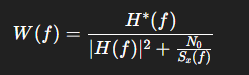
	​

(f)=TX power. This avoids amplifying noise where H(f)≈0.

6) Post-equalize at reception (inverse filtering)

Instead of pre-filtering TX, you can equalize the received signal before correlation (deconvolution).

Simple options: Wiener deconvolution, or regularized inverse filtering in frequency domain.

Be careful: inverse filtering amplifies noise in frequency bands where the channel has low gain. Use regularization.

7) Use adaptive matched filtering

Run an adaptive filter (LMS/RLS) to estimate channel distortions and update the matched filter to compensate.

Helpful if the channel changes over time (e.g., temperature or flow variations).

8) Sub-band / segmented chirps (frequency diversity)

Split the chirp sweep into several smaller sweeps (sub-bands) and process each separately.

If part of the band is heavily attenuated/distorted, the other sub-bands still give useful TOF info.

Combine results (voting, weighted averaging) for robust estimate.

9) Multipath handling and peak selection

Multipath creates multiple correlation peaks. Handling strategies:

Use windowing to reduce sidelobes so real peaks stand out.

Use threshold + gating: require consistency across multiple pings.

Use peak-tracking over pings to pick the stable direct-path peak.

Use deconvolution to separate overlapping echoes.

10) Doppler and motion: make the chirp Doppler-robust

For moving targets or strong flow-induced Doppler, consider:

Hyperbolic chirp (less sensitive to uniform scaling of time/frequency).

Shorter chirps (less time for Doppler to distort).

Estimate Doppler shift separately (FFT/heterodyne) and compensate before matching.

11) Use mismatched filters to reduce false alarms

Instead of perfect matched filter (which maximizes SNR for ideal channel), use a mismatched filter that trades off a bit of SNR for far lower sidelobes — helpful in multipath or reverberant environments.

12) Practical experiments to run (step-by-step)

Baseline: use your current LFM chirp and correlate → measure main peak height, width, and sidelobe levels.

Windowed chirp: apply Hanning/Tukey window → compare sidelobes vs main peak.

Shorter chirp: halve T, compare SNR and peak width.

Narrower chirp: reduce B, check robustness vs resolution.

NLFM / hyperbolic: generate NLFM and compare compressed pulse shape.

Sub-band: split chirp into two sub-bands, correlate each and combine.

Calibration: send a calibration ping, estimate H(f) and try simple Wiener equalization on RX; then correlate.

Golay: try complementary pulses and combine their matched-filter outputs.

13) Small code pointers (things to try in your Python)

Windowing:

w = np.hanning(len(chirp_sig))
chirp_sig_win = chirp_sig * w


Sub-band: split chirp_sig into chunks and correlate each.

Simple deconvolution in freq domain:

R = np.fft.rfft(rx_segment)
S = np.fft.rfft(tx_segment)
W = np.conj(S) / (np.abs(S)**2 + eps)     # simple Wiener-like inverse
rx_eq = np.fft.irfft(R * W)
corr_eq = correlate(rx_eq, tx_segment, mode='full')


(eps is a small regularizer to avoid division by zero.)

14) Trade-offs — keep this handy

More robustness ↔ less time resolution or lower processing gain.

Pre-equalization reduces distortion but increases complexity and risk of noise amplification.

Complementary codes reduce sidelobes but need extra time (multiple pulses).

Adaptive methods handle time-varying channels but require computation and converge time.

15) Concrete recommendation to start (for your research)

Try windowed LFM first (Hanning), see the sidelobe drop.

If multipath still confuses detection, try Golay complementary pairs (two pulses per measurement).

If frequency-dependent attenuation distorts spectrum, do a calibration ping + simple Wiener equalizer at RX before correlation.

If target/flow motion causes Doppler, try shorter chirps or hyperbolic chirps and/or estimate Doppler and correct for it before matching.